# LSTM pipeline

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

In [ ]:
CSV_PATH = '../running_data.csv'
LABEL_COLUMN = 'current_uc'
TEST_SIZE = 0.4
SEED = 32
EPOCHS = 80
BATCH_SIZE = 60 # 1 minute

In [129]:
# Load data
data_path = CSV_PATH
raw_df = pd.read_csv(data_path)

In [130]:
# Inspect data
print("\nData preview:")
raw_df.head()


Data preview:


,timestamp,amf_session_value,bearers_active_value,fivegs_amffunction_amf_authreject_value,fivegs_amffunction_amf_authreq_value,fivegs_amffunction_mm_confupdate_value,fivegs_amffunction_mm_confupdatesucc_value,fivegs_amffunction_mm_paging5greq_value,fivegs_amffunction_mm_paging5gsucc_value,fivegs_amffunction_rm_regemergreq_value,...,process_resident_memory_bytes_value,process_start_time_seconds_value,process_virtual_memory_bytes_value,process_virtual_memory_max_bytes_value,ran_ue_value,s5c_rx_createsession_value,s5c_rx_parse_failed_value,application,log_type,current_uc
0,2025-04-11 14:41:57,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,52657356.8,3.644742e+08,1.151508e+09,-1.0,0.0,0.0,0.0,0,0,uc6
1,2025-04-11 14:41:58,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,52657356.8,3.644742e+08,1.151508e+09,-1.0,0.0,0.0,0.0,0,0,uc6
2,2025-04-11 14:41:59,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,52657356.8,3.644742e+08,1.151508e+09,-1.0,0.0,0.0,0.0,0,0,uc6
3,2025-04-11 14:42:00,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,52657356.8,3.644742e+08,1.151508e+09,-1.0,0.0,0.0,0.0,0,0,uc6
4,2025-04-11 14:42:01,4.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,52657356.8,3.644742e+08,1.151508e+09,-1.0,0.0,0.0,0.0,0,0,uc6


In [131]:
# Drop any rows with missing values
raw_df.dropna(inplace=True)

In [132]:
# unique values in the application column
print(raw_df['application'].unique())
print(raw_df['log_type'].unique())

['0' 'amf' 'gmm' 'udm' 'upf' 'smf']
['0' 'registration' 'number_of_sessions_or_ues' 'nothing' 'remove']


In [ ]:
# Map application name to numeric values and log type to numeric values
app_map = { '0': 0, 'amf': 1, 'gmm': 2, 'udm': 3, 'smf': 4, 'upf': 5 }
log_map = { '0' : 0, 'registration' : 1, 'number_of_sessions_or_ues' : 2, 'nothing' : 3, 'remove' : 4 }


# Replace the application strings with mapped numeric values
raw_df['application'] = raw_df['application'].map(app_map)
raw_df['log_type'] = raw_df['log_type'].map(log_map)


In [134]:
# Encode label column if it exists
if LABEL_COLUMN in raw_df.columns:
    le = LabelEncoder()
    raw_df[LABEL_COLUMN] = le.fit_transform(raw_df[LABEL_COLUMN])
    print("\nLabel classes:", list(le.classes_))


Label classes: ['no_uc', 'uc2', 'uc3', 'uc6']


In [135]:
# Feature selection (exclude timestamp and label)
feature_cols = [col for col in raw_df.columns if col not in ['timestamp', LABEL_COLUMN]]
label_col = LABEL_COLUMN

In [136]:
# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(raw_df[feature_cols])

In [137]:
# Create sequences for LSTM
SEQUENCE_LENGTH = 10  # Number of time steps
X, y = [], []
for i in range(len(scaled_features) - SEQUENCE_LENGTH):
    X.append(scaled_features[i:i + SEQUENCE_LENGTH])
    y.append(raw_df[label_col].iloc[i + SEQUENCE_LENGTH])

X = np.array(X)
y = np.array(y)
y = to_categorical(y)

print(f"\nFinal shape -> X: {X.shape}, y: {y.shape}")


Final shape -> X: (1426, 10, 56), y: (1426, 4)


In [138]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [139]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(SEQUENCE_LENGTH, X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/davidtruhlar/Documents/FIIT/BP/5GDigitalTwin/Implementation/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [140]:
# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6224 - loss: 0.9295 - val_accuracy: 0.6427 - val_loss: 0.6697
Epoch 2/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7623 - loss: 0.6072 - val_accuracy: 0.8424 - val_loss: 0.5231
Epoch 3/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8512 - loss: 0.4673 - val_accuracy: 0.9282 - val_loss: 0.2846
Epoch 4/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.3104 - val_accuracy: 0.9177 - val_loss: 0.2813
Epoch 5/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9058 - loss: 0.3178 - val_accuracy: 0.9247 - val_loss: 0.2615
Epoch 6/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9177 - loss: 0.3028 - val_accuracy: 0.9089 - val_loss: 0.3050
Epoch 7/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.2738 - val_accuracy: 0.9089 - val_loss: 0.2834
Epoch 8/80
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.3576 - val_accuracy: 0.

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9310 - loss: 0.1153

Test Accuracy: 0.9177


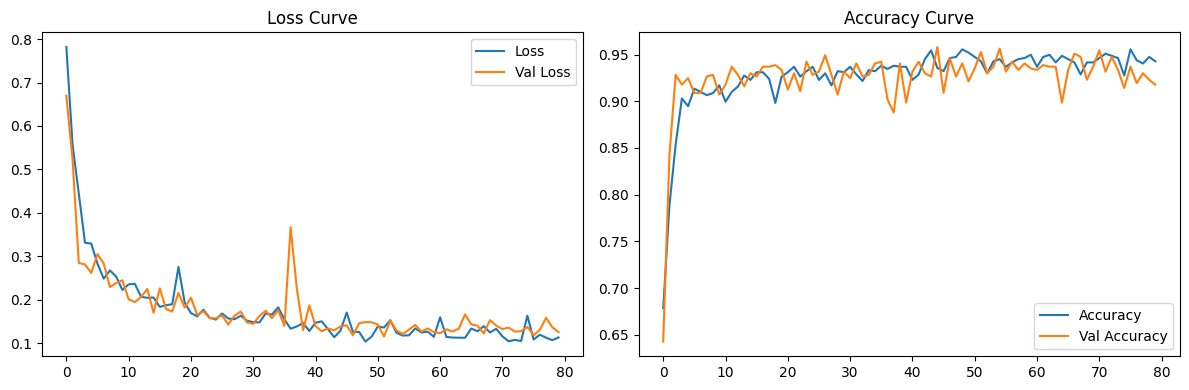

In [141]:
# Evaluate model
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
